In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, ElasticNet
from yellowbrick.regressor import ResidualsPlot
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper

In [2]:
pd.set_option("display.max_columns", 99)
df = pd.read_csv("../data/mergeA_for_modeling.csv")
df.head(n=3)


,Year,STNAM,FIPST,LEAID,LEANM,NCESSCH,SCHNAM,ALL_COHORT_,school_name,zip_mailing,zip_location,latitude,urban_centric_locale,county_code,school_level,school_type,lowest_grade_offered,highest_grade_offered,title_i_status,title_i_eligible,charter,magnet,virtual,teachers_fte,free_lunch,reduced_price_lunch,free_or_reduced_price_lunch,enrollment,ungrade_cedp,Math_Pct_Part,Rla_Pct_Part,ALL_RATE_
0,2012,ALASKA,2,200001,Lower Kuskokwim School District,20000100208,Bethel Regional High School,75,BETHEL REGIONAL HIGH SCHOOL,99559.0,99559.0,60.802584,41.0,2050.0,4.0,1.0,6.0,12.0,5.0,1.0,0.0,0.0,0.0,32.849998,210.0,28.0,238.0,506.0,0.0,97.5,97.5,52.0
1,2012,ALASKA,2,200001,Lower Kuskokwim School District,20000100318,Bethel Alternative Boarding School,28,BETHEL ALTERNATIVE BOARDING SCHOOL,99559.0,99559.0,60.795960,33.0,2050.0,3.0,4.0,8.0,12.0,5.0,1.0,0.0,0.0,0.0,4.000000,58.0,0.0,58.0,61.0,0.0,90.0,90.0,10.0
2,2012,ALASKA,2,200006,Mount Edgecumbe High School Agency,20000600558,Mt. Edgecumbe High School,71,MT. EDGECUMBE HIGH SCHOOL,99835.0,99835.0,57.051810,41.0,2220.0,3.0,1.0,9.0,12.0,5.0,1.0,0.0,0.0,0.0,22.500000,224.0,35.0,259.0,398.0,0.0,97.5,97.5,97.5


In [4]:
# Subset to columns that we believe have unique information in them; e.g. removing ID columns, names as strings
# Categoricals like LEAID, zip_location, and county_code like have some useful information but may have too many categories (1000s) to dummy encode.
# I am including the county_code in this test.
X = df.copy()
X.drop(["STNAM", "LEANM", "NCESSCH", "SCHNAM", "zip_mailing",
       "LEAID", "school_name", "zip_location"], inplace=True, axis=1)

y = X.pop("ALL_RATE_")


In [5]:
# Tag categoricals so that they can be treated properly by the modeling packages
numeric_cols = ["Rla_Pct_Part", "Math_Pct_Part", "enrollment", "free_lunch", "reduced_price_lunch", "free_or_reduced_price_lunch",
                "teachers_fte", "lowest_grade_offered", "highest_grade_offered", "latitude", "ALL_COHORT_", "Year"]
for col in numeric_cols:
    assert col in X.columns
categoricals = list(set(X.columns.tolist()) - set(numeric_cols))


In [6]:
# Convert categoricals to the pandas type 'category'
for col in categoricals:
    X[col] = X[col].astype("category")
X.dtypes

Year                              int64
FIPST                          category
ALL_COHORT_                       int64
latitude                        float64
urban_centric_locale           category
county_code                    category
school_level                   category
school_type                    category
lowest_grade_offered            float64
highest_grade_offered           float64
title_i_status                 category
title_i_eligible               category
charter                        category
magnet                         category
virtual                        category
teachers_fte                    float64
free_lunch                      float64
reduced_price_lunch             float64
free_or_reduced_price_lunch     float64
enrollment                      float64
ungrade_cedp                   category
Math_Pct_Part                   float64
Rla_Pct_Part                    float64
dtype: object

In [7]:
# Create train-test split
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42)


In [8]:
Xtrain.head(n=2)

,Year,FIPST,ALL_COHORT_,latitude,urban_centric_locale,county_code,school_level,school_type,lowest_grade_offered,highest_grade_offered,title_i_status,title_i_eligible,charter,magnet,virtual,teachers_fte,free_lunch,reduced_price_lunch,free_or_reduced_price_lunch,enrollment,ungrade_cedp,Math_Pct_Part,Rla_Pct_Part
33884,2015,6,175,34.095930,21.0,6037.0,3.0,4.0,9.0,12.0,5.0,1.0,0.0,0.0,0.0,15.00,253.0,23.0,276.0,318.0,0.0,92.0,92.0
54097,2016,48,237,30.324213,11.0,48453.0,3.0,1.0,9.0,12.0,5.0,1.0,0.0,0.0,0.0,94.32,934.0,85.0,1019.0,1255.0,0.0,97.5,87.0


In [9]:
# Show our stratification on y. They have very similar distributions
ytrain.describe() - ytest.describe()

count    41828.000000
mean        -0.019808
std          0.020756
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.000000
Name: ALL_RATE_, dtype: float64

# ElasticNetCV Regularized Regression with Polynomial Features

## Tuning

In [10]:
# set up the wrapper with the StandardScaler
scaler = SklearnTransformerWrapper(transformer=StandardScaler(),
                                   variables=numeric_cols)

polynomials = SklearnTransformerWrapper(transformer=PolynomialFeatures(degree=2),variables=numeric_cols)

# Find the optimal L1 and alpha parameters
# Note that various l1_ratio values were tried and 1.0 was found to be the best fit.
pipe = Pipeline(steps=[("scaler", scaler), ("onehot", OneHotEncoder(drop_last=True, variables=categoricals)),("polys",polynomials),
                ("elasticnet", ElasticNetCV(l1_ratio=[1.0],random_state=42,max_iter=2000,n_jobs=4))])


In [11]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pipe.fit(X=Xtrain, y=ytrain)
residual

/home/bb/miniconda3/envs/my-env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5123.75339105539, tolerance: 1899.3115103179664
  model = cd_fast.enet_coordinate_descent_gram(
/home/bb/miniconda3/envs/my-env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4285.286676499993, tolerance: 1895.050015805176
  model = cd_fast.enet_coordinate_descent_gram(
/home/bb/miniconda3/envs/my-env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3895.2481657229364, tolerance: 1897.4045475056776
  model = cd_fast.enet_coordinate_descent_gram(
/home/bb/miniconda3/envs/my-env/lib/py

Pipeline(steps=[('scaler',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['Rla_Pct_Part',
                                                      'Math_Pct_Part',
                                                      'enrollment',
                                                      'free_lunch',
                                                      'reduced_price_lunch',
                                                      'free_or_reduced_price_lunch',
                                                      'teachers_fte',
                                                      'lowest_grade_offered',
                                                      'highest_grade_offered',
                                                      'latitude', 'ALL_COHORT_',
                                                      'Year'])),
                ('onehot',
                 OneHotEncoder(drop_last=True,
                               variables=['v...
                 SklearnTransformerWrapper(transformer=PolynomialFeatures(),
                                           variables=['Rla_Pct_Part',
                                                      'Math_Pct_Part',
                                                      'enrollment',
                                                      'free_lunch',
                                                      'reduced_price_lunch',
                                                      'free_or_reduced_price_lunch',
                                                      'teachers_fte',
                                                      'lowest_grade_offered',
                                                      'highest_grade_offered',
                                                      'latitude', 'ALL_COHORT_',
                                                      'Year'])),
                ('elasticnet',
                 ElasticNetCV(l1_ratio=[1.0], max_iter=2000, n_jobs=4,
                              random_state=42))])

In [14]:
# Verifying that the parameters taken by the model correctly
best_alpha = pipe._final_estimator.alpha_
best_l1_ratio = pipe._final_estimator.l1_ratio_
print("Optimal alpha:", best_alpha) 
print("Optimal l1 ratio:", best_l1_ratio) 
print("Number of iterations:", pipe._final_estimator.n_iter_)


Optimal alpha: 0.027426207894190428
Optimal l1 ratio: 1.0
Number of iterations: 2000


The optimal value is found to be a full Lasso penalty

In [15]:
# Run Model at the optimal values
pipe2 = Pipeline(steps=[("scaler", scaler), ("onehot", OneHotEncoder(drop_last=True, variables=categoricals)),("polys",polynomials),
                ("elasticnet", ElasticNet(l1_ratio=best_l1_ratio,alpha=best_alpha,random_state=42))])


/home/bb/miniconda3/envs/my-env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.459e+04, tolerance: 2.374e+03
  model = cd_fast.enet_coordinate_descent(


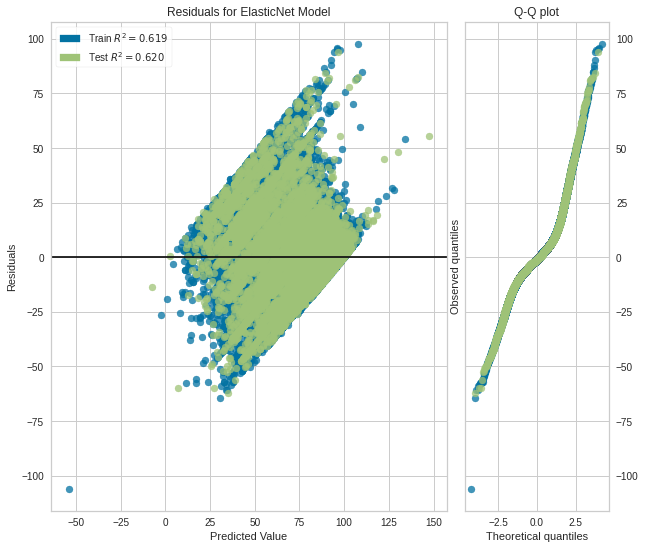

<AxesSubplot:title={'center':'Residuals for ElasticNet Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [16]:
pipe2.fit(Xtrain,ytrain)
plt.rcParams['figure.figsize'] = (10,9)
visualizer = ResidualsPlot(pipe2, hist=False,qqplot=True)
visualizer.fit(Xtrain, ytrain)
visualizer.score(Xtest, ytest)
visualizer.show()

In [17]:
residuals = ytest - pipe2.predict(Xtest) 
print("RMSE on the test set=", residuals.describe()[2])

RMSE on the test set= 11.977932218202747


110 features, reduction of 95.52%


<AxesSubplot:>

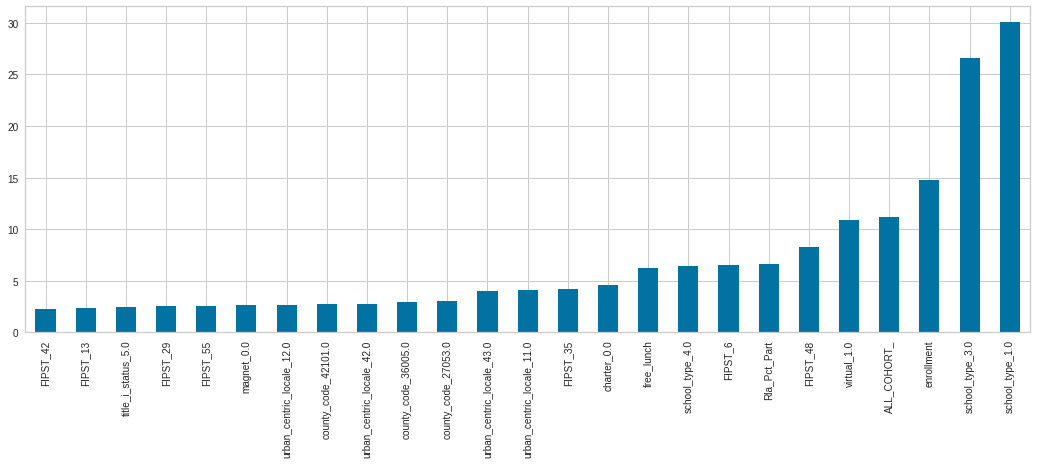

In [18]:
# Feature Importance

feature_importance = pd.Series(
    index=visualizer._final_estimator.feature_names_in_, data=np.abs(visualizer._final_estimator.coef_))

n_selected_features = (feature_importance > 0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features, (1-n_selected_features/len(feature_importance))*100))

feature_importance.sort_values().tail(25).plot(kind='bar', figsize=(18, 6))


In [19]:
visualizer._final_estimator.get_params()

{'alpha': 0.027426207894190428,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 1.0,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': 42,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [20]:
pipe2.get_params()

{'memory': None,
 'steps': [('scaler',
   SklearnTransformerWrapper(transformer=StandardScaler(),
                             variables=['Rla_Pct_Part', 'Math_Pct_Part',
                                        'enrollment', 'free_lunch',
                                        'reduced_price_lunch',
                                        'free_or_reduced_price_lunch',
                                        'teachers_fte', 'lowest_grade_offered',
                                        'highest_grade_offered', 'latitude',
                                        'ALL_COHORT_', 'Year'])),
  ('onehot',
   OneHotEncoder(drop_last=True,
                 variables=['virtual', 'title_i_status', 'school_level',
                            'ungrade_cedp', 'FIPST', 'school_type', 'charter',
                            'county_code', 'urban_centric_locale',
                            'title_i_eligible', 'magnet'])),
  ('polys',
   SklearnTransformerWrapper(transformer=PolynomialFeatures(),
   